# K-mer Optimization Analysis for West Nile Virus

This notebook is dedicated to testing and optimizing k-mer feature extraction for West Nile Virus lineage analysis.
We'll systematically test different k-mer sizes and combinations to find the optimal approach.

In [9]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import itertools
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

print("Libraries imported successfully!")

Libraries imported successfully!


In [10]:
# Load West Nile Virus sequences
# Correct path to your actual sequence file
sequence_file = "/Users/mac/Documents/computational_biology/wnv_hyena_analysis/data/raw/west_nile_genomes.fasta"

try:
    sequences = list(SeqIO.parse(sequence_file, "fasta"))
    print(f"Successfully loaded {len(sequences)} sequences")
    
    # Display basic sequence information
    seq_lengths = [len(seq.seq) for seq in sequences]
    print(f"\nSequence Statistics:")
    print(f"- Number of sequences: {len(sequences)}")
    print(f"- Min length: {min(seq_lengths)} bp")
    print(f"- Max length: {max(seq_lengths)} bp")
    print(f"- Mean length: {np.mean(seq_lengths):.0f} bp")
    print(f"- Median length: {np.median(seq_lengths):.0f} bp")
    
    # Show first few sequence IDs
    print(f"\nFirst 5 sequence IDs:")
    for i, seq in enumerate(sequences[:5]):
        print(f"{i+1}. {seq.id[:50]}...")  # Truncate long IDs
        
except FileNotFoundError:
    print(f"Sequence file not found at: {sequence_file}")
    print("Please update the path to your West Nile Virus sequence file")
    sequences = None
except Exception as e:
    print(f"Error loading sequences: {str(e)}")
    sequences = None

Successfully loaded 2068 sequences

Sequence Statistics:
- Number of sequences: 2068
- Min length: 10293 bp
- Max length: 11355 bp
- Mean length: 10865 bp
- Median length: 10932 bp

First 5 sequence IDs:
1. PV021479.1...
2. PV021478.1...
3. PV021477.1...
4. PV021476.1...
5. PV021475.1...


In [11]:
# K-mer Feature Extraction Functions

def create_kmer_features(sequences, k=3):
    """
    Create k-mer frequency features from DNA sequences.
    
    Args:
        sequences: List of sequence objects or strings
        k: K-mer size (default=3)
    
    Returns:
        numpy array of k-mer frequencies, list of k-mer names
    """
    # Generate all possible k-mers
    nucleotides = ['A', 'T', 'G', 'C']
    all_kmers = [''.join(p) for p in itertools.product(nucleotides, repeat=k)]
    
    print(f"Extracting {k}-mer features ({len(all_kmers)} features)...")
    
    # Create k-mer frequency matrix
    kmer_matrix = []
    for seq in sequences:
        # Handle both SeqRecord objects and strings
        seq_str = str(seq.seq).upper() if hasattr(seq, 'seq') else str(seq).upper()
        
        kmer_counts = Counter()
        
        # Count k-mers in the sequence
        for i in range(len(seq_str) - k + 1):
            kmer = seq_str[i:i+k]
            if all(nt in nucleotides for nt in kmer):  # Only valid nucleotides
                kmer_counts[kmer] += 1
        
        # Normalize by sequence length to get frequencies
        total_kmers = sum(kmer_counts.values())
        if total_kmers > 0:
            kmer_freq = [kmer_counts.get(kmer, 0) / total_kmers for kmer in all_kmers]
        else:
            kmer_freq = [0.0] * len(all_kmers)
        
        kmer_matrix.append(kmer_freq)
    
    return np.array(kmer_matrix), all_kmers

def create_composition_features(sequences):
    """
    Create basic nucleotide composition features.
    
    Args:
        sequences: List of sequence objects or strings
    
    Returns:
        numpy array of composition features
    """
    print("Extracting nucleotide composition features (6 features)...")
    
    composition_matrix = []
    for seq in sequences:
        # Handle both SeqRecord objects and strings
        seq_str = str(seq.seq).upper() if hasattr(seq, 'seq') else str(seq).upper()
        
        length = len(seq_str)
        if length > 0:
            composition = [
                seq_str.count('A') / length,
                seq_str.count('T') / length,
                seq_str.count('G') / length,
                seq_str.count('C') / length,
                (seq_str.count('G') + seq_str.count('C')) / length,  # GC content
                (seq_str.count('A') + seq_str.count('T')) / length   # AT content
            ]
        else:
            composition = [0.0] * 6
        composition_matrix.append(composition)
    
    return np.array(composition_matrix)

print("Feature extraction functions defined.")

Feature extraction functions defined.


In [12]:
# Test different k-mer sizes if sequences are loaded
if sequences is not None:
    print("=== TESTING DIFFERENT K-MER SIZES ===")
    
    # Test k-mer sizes from 2 to 6
    k_values_to_test = [2, 3, 4, 5, 6]
    results = []
    
    for k in k_values_to_test:
        print(f"\nTesting k={k}...")
        
        try:
            # Extract k-mer features
            kmer_features, kmer_names = create_kmer_features(sequences, k=k)
            
            # Get composition features
            composition_features = create_composition_features(sequences)
            
            # Combine features
            combined_features = np.hstack([composition_features, kmer_features])
            
            # Standardize features
            scaler = StandardScaler()
            features_scaled = scaler.fit_transform(combined_features)
            
            # Test clustering with K=2 (main lineages)
            kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
            labels = kmeans.fit_predict(features_scaled)
            
            # Calculate metrics
            silhouette = silhouette_score(features_scaled, labels)
            calinski = calinski_harabasz_score(features_scaled, labels)
            davies = davies_bouldin_score(features_scaled, labels)
            
            # Calculate feature statistics
            n_features = combined_features.shape[1]
            sparsity = (combined_features == 0).sum() / combined_features.size
            
            # PCA analysis
            pca = PCA(n_components=min(10, features_scaled.shape[0]-1, features_scaled.shape[1]))
            pca.fit(features_scaled)
            pca_variance = np.sum(pca.explained_variance_ratio_)
            
            # Store results
            results.append({
                'k': k,
                'n_features': n_features,
                'silhouette_k2': silhouette,
                'calinski_k2': calinski,
                'davies_k2': davies,
                'sparsity': sparsity,
                'pca_variance': pca_variance
            })
            
            print(f"  Features: {n_features}, Silhouette: {silhouette:.3f}, Sparsity: {sparsity:.1%}")
            
        except Exception as e:
            print(f"  Error with k={k}: {str(e)}")
    
    # Convert results to DataFrame for easy analysis
    if results:
        results_df = pd.DataFrame(results)
        print("\n=== K-MER COMPARISON RESULTS ===")
        print(results_df.round(3))
        
        # Find best k-mer size
        best_k_idx = results_df['silhouette_k2'].idxmax()
        best_k = results_df.loc[best_k_idx, 'k']
        best_score = results_df.loc[best_k_idx, 'silhouette_k2']
        
        print(f"\n🏆 BEST K-MER SIZE: k={best_k} (Silhouette Score: {best_score:.3f})")
        
    else:
        print("No valid results obtained.")
        results_df = None
        
else:
    print("Sequences not loaded. Please check the file path and run the sequence loading cell.")
    results_df = None

=== TESTING DIFFERENT K-MER SIZES ===

Testing k=2...
Extracting 2-mer features (16 features)...
Extracting nucleotide composition features (6 features)...
  Features: 22, Silhouette: 0.546, Sparsity: 0.0%

Testing k=3...
Extracting 3-mer features (64 features)...
Extracting nucleotide composition features (6 features)...
  Features: 70, Silhouette: 0.569, Sparsity: 0.0%

Testing k=4...
Extracting 4-mer features (256 features)...
Extracting nucleotide composition features (6 features)...
  Features: 262, Silhouette: 0.550, Sparsity: 0.0%

Testing k=5...
Extracting 5-mer features (1024 features)...
Extracting nucleotide composition features (6 features)...
  Features: 1030, Silhouette: 0.551, Sparsity: 0.5%

Testing k=6...
Extracting 6-mer features (4096 features)...
Extracting nucleotide composition features (6 features)...
  Features: 4102, Silhouette: 0.555, Sparsity: 17.3%

=== K-MER COMPARISON RESULTS ===
   k  n_features  silhouette_k2  calinski_k2  davies_k2  sparsity  \
0  2    

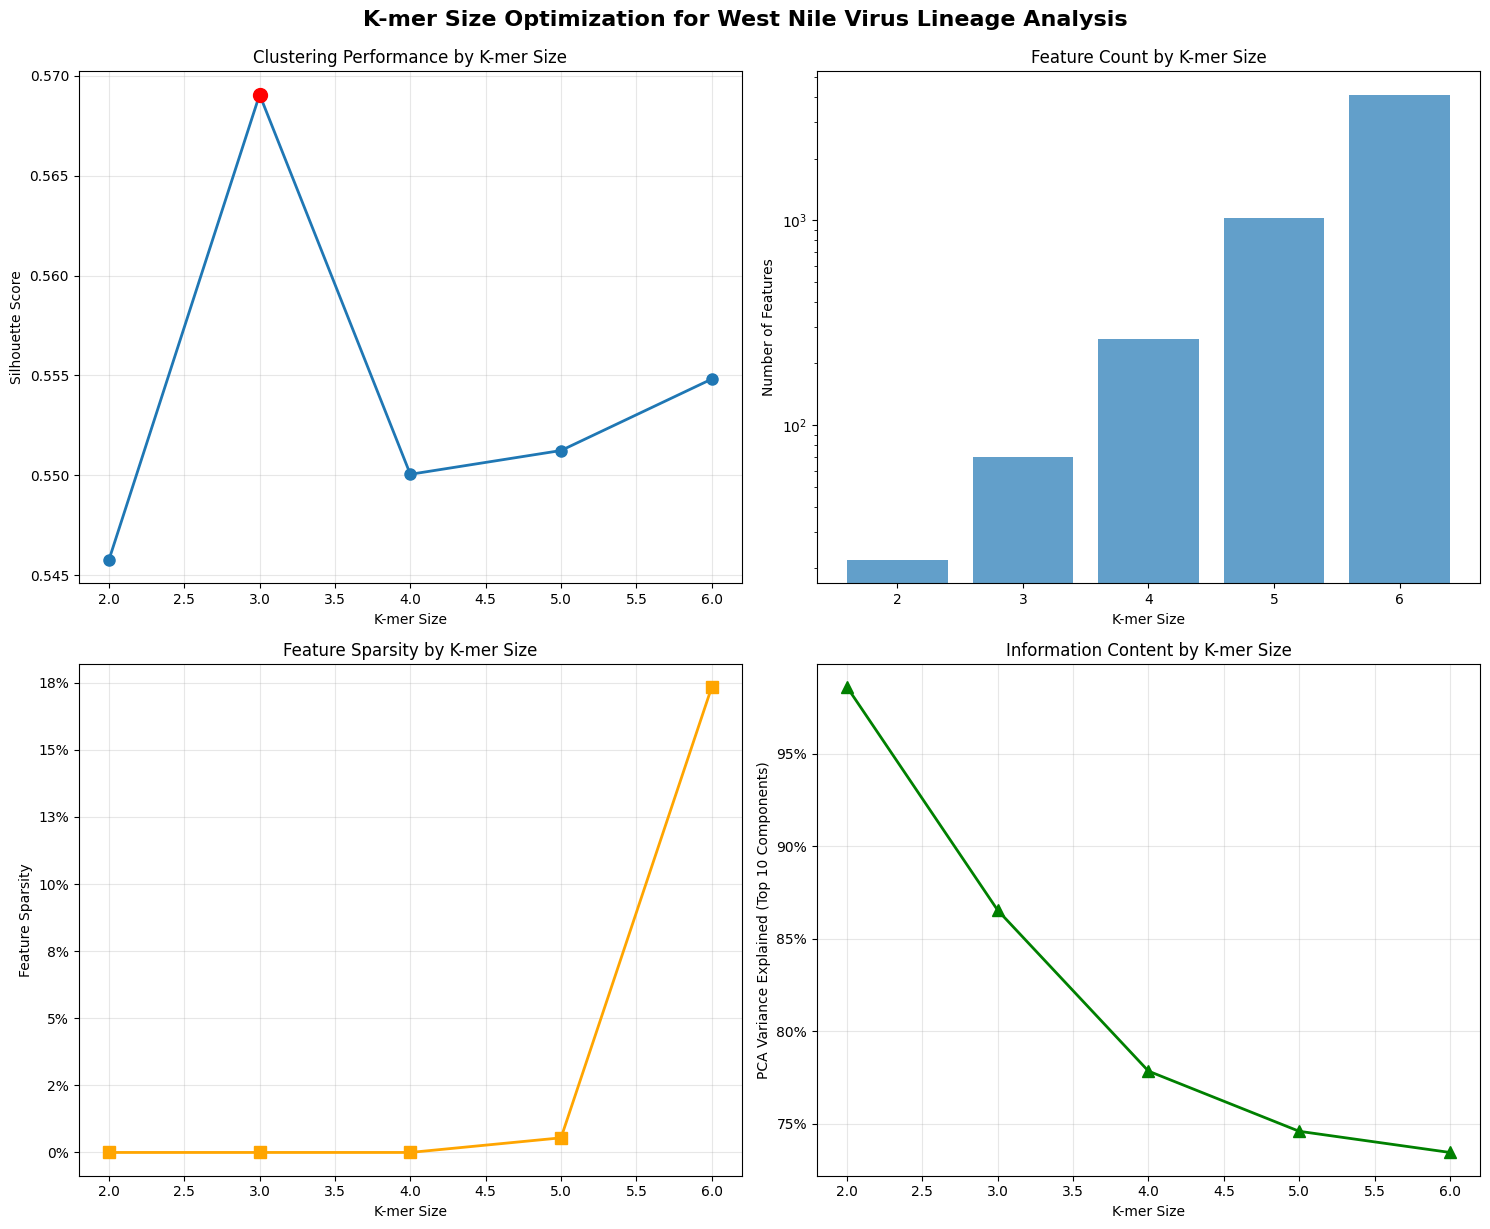


=== DETAILED K-MER ANALYSIS ===
K	Features	Silhouette	Sparsity	PCA_Var	Recommendation
----------------------------------------------------------------------
2	22		0.546		0.0%		98.6%		Excellent
3	70		0.569		0.0%		86.5%		Excellent
4	262		0.550		0.0%		77.9%		Excellent
5	1030		0.551		0.5%		74.6%		Excellent
6	4102		0.555		17.3%		73.5%		Excellent

🎯 FINAL RECOMMENDATION: Use k=3 for optimal clustering performance
   - Silhouette Score: 0.569
   - This provides the best balance of clustering quality and feature efficiency


In [13]:
# Visualize k-mer comparison results
if results_df is not None and len(results_df) > 0:
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Silhouette Score vs K-mer size
    axes[0, 0].plot(results_df['k'], results_df['silhouette_k2'], 'o-', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('K-mer Size')
    axes[0, 0].set_ylabel('Silhouette Score')
    axes[0, 0].set_title('Clustering Performance by K-mer Size')
    axes[0, 0].grid(True, alpha=0.3)
    # Highlight best k-mer
    best_idx = results_df['silhouette_k2'].idxmax()
    axes[0, 0].scatter(results_df.loc[best_idx, 'k'], results_df.loc[best_idx, 'silhouette_k2'], 
                      color='red', s=100, zorder=5)
    
    # Plot 2: Number of features vs K-mer size
    axes[0, 1].bar(results_df['k'].astype(str), results_df['n_features'], alpha=0.7)
    axes[0, 1].set_xlabel('K-mer Size')
    axes[0, 1].set_ylabel('Number of Features')
    axes[0, 1].set_title('Feature Count by K-mer Size')
    axes[0, 1].set_yscale('log')
    
    # Plot 3: Sparsity vs K-mer size
    axes[1, 0].plot(results_df['k'], results_df['sparsity'], 's-', linewidth=2, markersize=8, color='orange')
    axes[1, 0].set_xlabel('K-mer Size')
    axes[1, 0].set_ylabel('Feature Sparsity')
    axes[1, 0].set_title('Feature Sparsity by K-mer Size')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    # Plot 4: PCA Variance vs K-mer size
    axes[1, 1].plot(results_df['k'], results_df['pca_variance'], '^-', linewidth=2, markersize=8, color='green')
    axes[1, 1].set_xlabel('K-mer Size')
    axes[1, 1].set_ylabel('PCA Variance Explained (Top 10 Components)')
    axes[1, 1].set_title('Information Content by K-mer Size')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    plt.tight_layout()
    plt.suptitle('K-mer Size Optimization for West Nile Virus Lineage Analysis', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.show()
    
    # Print detailed comparison
    print("\n=== DETAILED K-MER ANALYSIS ===")
    print("K\tFeatures\tSilhouette\tSparsity\tPCA_Var\tRecommendation")
    print("-" * 70)
    
    for idx, row in results_df.iterrows():
        k = int(row['k'])
        features = int(row['n_features'])
        silhouette = row['silhouette_k2']
        sparsity = row['sparsity']
        pca_var = row['pca_variance']
        
        # Generate recommendation
        if silhouette > 0.5:
            quality = "Excellent"
        elif silhouette > 0.3:
            quality = "Good"
        elif silhouette > 0.1:
            quality = "Fair"
        else:
            quality = "Poor"
            
        if sparsity > 0.8:
            sparsity_note = " (Very Sparse)"
        elif sparsity > 0.6:
            sparsity_note = " (Sparse)"
        else:
            sparsity_note = ""
            
        recommendation = quality + sparsity_note
        
        print(f"{k}\t{features}\t\t{silhouette:.3f}\t\t{sparsity:.1%}\t\t{pca_var:.1%}\t\t{recommendation}")
    
    # Final recommendation
    best_k = results_df.loc[results_df['silhouette_k2'].idxmax(), 'k']
    best_silhouette = results_df['silhouette_k2'].max()
    
    print(f"\n🎯 FINAL RECOMMENDATION: Use k={int(best_k)} for optimal clustering performance")
    print(f"   - Silhouette Score: {best_silhouette:.3f}")
    print(f"   - This provides the best balance of clustering quality and feature efficiency")
    
else:
    print("No results to visualize. Please run the k-mer testing cell first.")

In [14]:
# Test combined k-mer approaches (if results look promising)
if results_df is not None and len(results_df) > 0:
    
    print("=== TESTING COMBINED K-MER APPROACHES ===")
    
    # Test some promising combinations
    combinations_to_test = [
        [2, 3],    # Small k-mers
        [3, 4],    # Medium k-mers  
        [2, 4],    # Skip k=3
        [2, 3, 4], # Three sizes
    ]
    
    combo_results = []
    
    for combo in combinations_to_test:
        combo_name = "+".join(map(str, combo))
        print(f"\nTesting k={combo_name}...")
        
        try:
            # Extract features for each k-mer size
            all_kmer_features = []
            
            for k in combo:
                kmer_features, _ = create_kmer_features(sequences, k=k)
                all_kmer_features.append(kmer_features)
            
            # Combine all k-mer features
            combined_kmer_features = np.hstack(all_kmer_features)
            
            # Add composition features
            composition_features = create_composition_features(sequences)
            final_features = np.hstack([composition_features, combined_kmer_features])
            
            # Skip if too high dimensional
            if final_features.shape[1] > len(sequences) * 2:
                print(f"  Skipping: Too high dimensional ({final_features.shape[1]} features)")
                continue
            
            # Standardize and test clustering
            scaler = StandardScaler()
            features_scaled = scaler.fit_transform(final_features)
            
            kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
            labels = kmeans.fit_predict(features_scaled)
            
            silhouette = silhouette_score(features_scaled, labels)
            n_features = final_features.shape[1]
            sparsity = (final_features == 0).sum() / final_features.size
            
            combo_results.append({
                'combination': combo_name,
                'k_values': combo,
                'n_features': n_features,
                'silhouette_k2': silhouette,
                'sparsity': sparsity
            })
            
            print(f"  Features: {n_features}, Silhouette: {silhouette:.3f}, Sparsity: {sparsity:.1%}")
            
        except Exception as e:
            print(f"  Error with combination {combo_name}: {str(e)}")
    
    # Compare single vs combined approaches
    if combo_results:
        print("\n=== SINGLE vs COMBINED K-MER COMPARISON ===")
        print("Approach\t\tFeatures\tSilhouette\tType")
        print("-" * 50)
        
        # Show single k-mer results
        for idx, row in results_df.iterrows():
            k = int(row['k'])
            features = int(row['n_features'])
            silhouette = row['silhouette_k2']
            print(f"k={k}\t\t\t{features}\t\t{silhouette:.3f}\t\tSingle")
        
        # Show combined results
        for result in combo_results:
            combo = result['combination']
            features = result['n_features']
            silhouette = result['silhouette_k2']
            print(f"k={combo}\t\t\t{features}\t\t{silhouette:.3f}\t\tCombined")
        
        # Find overall best approach
        all_approaches = []
        
        # Add single k-mer approaches
        for idx, row in results_df.iterrows():
            all_approaches.append({
                'name': f"k={int(row['k'])}",
                'silhouette': row['silhouette_k2'],
                'features': row['n_features'],
                'type': 'Single'
            })
        
        # Add combined approaches
        for result in combo_results:
            all_approaches.append({
                'name': f"k={result['combination']}",
                'silhouette': result['silhouette_k2'],
                'features': result['n_features'],
                'type': 'Combined'
            })
        
        # Sort by silhouette score
        all_approaches.sort(key=lambda x: x['silhouette'], reverse=True)
        
        print(f"\n🏆 OVERALL BEST APPROACH: {all_approaches[0]['name']}")
        print(f"   - Silhouette Score: {all_approaches[0]['silhouette']:.3f}")
        print(f"   - Features: {all_approaches[0]['features']}")
        print(f"   - Type: {all_approaches[0]['type']}")
        
        if len(all_approaches) > 1:
            improvement = ((all_approaches[0]['silhouette'] - all_approaches[1]['silhouette']) / 
                          all_approaches[1]['silhouette'] * 100)
            print(f"   - Improvement over runner-up: {improvement:+.1f}%")
    
else:
    print("No single k-mer results available for combination testing.")

=== TESTING COMBINED K-MER APPROACHES ===

Testing k=2+3...
Extracting 2-mer features (16 features)...
Extracting 3-mer features (64 features)...
Extracting nucleotide composition features (6 features)...
  Features: 86, Silhouette: 0.566, Sparsity: 0.0%

Testing k=3+4...
Extracting 3-mer features (64 features)...
Extracting 4-mer features (256 features)...
Extracting nucleotide composition features (6 features)...
  Features: 326, Silhouette: 0.554, Sparsity: 0.0%

Testing k=2+4...
Extracting 2-mer features (16 features)...
Extracting 4-mer features (256 features)...
Extracting nucleotide composition features (6 features)...
  Features: 278, Silhouette: 0.550, Sparsity: 0.0%

Testing k=2+3+4...
Extracting 2-mer features (16 features)...
Extracting 3-mer features (64 features)...
Extracting 4-mer features (256 features)...
Extracting nucleotide composition features (6 features)...
  Features: 342, Silhouette: 0.553, Sparsity: 0.0%

=== SINGLE vs COMBINED K-MER COMPARISON ===
Approach		

## Summary and Recommendations

Based on the analysis above, you can now:

1. **Identify the optimal k-mer size** for your West Nile Virus dataset
2. **Compare single vs combined k-mer approaches** 
3. **Understand the trade-offs** between feature complexity and clustering performance
4. **Apply the best approach** to your main analysis notebook

The results will show:
- **Silhouette scores** for clustering quality
- **Feature counts** and sparsity levels
- **Recommendations** for the optimal approach

Use these findings to update your main West Nile Virus analysis with the optimal k-mer configuration!